# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber import get_uniform_ms, get_finkelstein_ms

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xix2iy6x because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.


0.1.1-ga


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [5]:
target_idx = label_annot['wtCas9_cleave_rate_log']

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.1-ga


In [7]:
#kinn_model_space = get_uniform_ms(n_states=4, st_win_size=7)

#print(kinn_model_space)

In [8]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [9]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,  # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
        )

## Components before they are implemented in AMBER

In [10]:
## NEEDS RE-WORK
# poorman's manager get reward
def get_reward_pipeline(model_arcs, wd="./outputs/"):
    from warnings import simplefilter
    simplefilter(action='ignore', category=DeprecationWarning)
    tf.reset_default_graph()
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    model_params = modelSpace_to_modelParams(model_arcs)
    pickle.dump(model_params, open(os.path.join(wd, "model_params.pkl"), "wb"))
    with train_graph.as_default(), train_sess.as_default():
        kinn_test = KineticModel(model_params)
        mb = KineticNeuralNetworkBuilder(kinn=kinn_test, session=train_sess, 
            n_feats=25,
            n_channels=8,
            replace_conv_by_fc=False)
        # train and test
        mb.build(optimizer='adam', plot=False, output_act=False)
        model = mb.model
        x_train_b = mb.blockify_seq_ohe(x_train)
        x_test_b = mb.blockify_seq_ohe(x_test)
        checkpointer = ModelCheckpoint(
            filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
            save_weights_only=True)
        earlystopper = EarlyStopping(
            monitor="val_loss",
            mode='min',
            patience=5,
            verbose=0)

        model.fit(x_train_b, y_train[:,target_idx],
                  batch_size=128,
                  validation_split=0.2,
                  callbacks=[checkpointer, earlystopper],
                  epochs=300, verbose=0)
        y_hat = model.predict(x_test_b).flatten()
        test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]
    tf.keras.backend.clear_session()
    del train_graph, train_sess
    gc.collect()
    return test_pcc

## A fancy For-Loop that does the work for `amber.architect.trainEnv`

In [11]:
# trainEnv parameters
samps_per_gen = 10   # how many arcs to sample in each generation; important
max_gen = 1500
epsilon = 0.05
patience = 200
n_warmup_gen = -1
wd = "outputs/notebook"

In [12]:
def compute_eps(model_space_probs, old_probs=None):
    delta = []
    samp_probs = {}
    for p in model_space_probs:
        #print(p)
        samp_probs[p] = model_space_probs[p].sample(size=10000)
        n = np.percentile(samp_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
        if old_probs is None:
            delta.append( np.mean(np.abs(n)) )
        else:
            o = np.percentile(old_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
            delta.append( np.mean(np.abs(o - n)) )
    return np.mean(delta), samp_probs 

# get prior probas
_, old_probs = compute_eps(controller.model_space_probs)

In [13]:
hist = []
pc_cnt = 0
best_indv = 0
stat_df = pd.DataFrame(columns=['Generation', 'GenAvg', 'Best', 'PostVar'])
for generation in range(max_gen):
    try:
        start = time.time()
        has_impr = False
        for _ in range(samps_per_gen):
            # get arc
            arc, _ = controller.get_action()
            # get reward
            try:
                test_pcc = get_reward_pipeline(arc, wd=wd)
            #except ValueError:
            #    test_pcc = 0
            except Exception as e:
                raise e
            rate_df = None
            # update best, or increase patience counter
            if test_pcc > best_indv:
                best_indv = test_pcc
                has_impr = True
                shutil.move(os.path.join(wd, "bestmodel.h5"), os.path.join(wd, "AmberSearchBestModel.h5"))
                shutil.move(os.path.join(wd, "model_params.pkl"), os.path.join(wd, "AmberSearchBestModel_config.pkl"))

            # store
            _ = controller.store(action=arc, reward=test_pcc)
            hist.append({'gen': generation, 'arc':arc, 'test_pcc': test_pcc, 'rate_df': rate_df})
        end = time.time()
        if generation < n_warmup_gen:
            print(f"Gen {generation} < {n_warmup_gen} warmup.. skipped - Time %.2f" % (end-start), flush=True)
            continue
        _ = controller.train(episode=generation, working_dir=".")
        delta, old_probs = compute_eps(controller.model_space_probs, old_probs)
        post_vars = [np.var(x.sample(size=100)) for _, x in controller.model_space_probs.items()]
        stat_df = stat_df.append({
            'Generation': generation,
            'GenAvg': controller.buffer.r_bias,
            'Best': best_indv,
            'PostVar': np.mean(post_vars)
        }, ignore_index=True)
        print("[%s] Gen %i - Mean fitness %.3f - Best %.4f - PostVar %.3f - Eps %.3f - Time %.2f" % (
            datetime.now().strftime("%H:%M:%S"),
            generation, 
            controller.buffer.r_bias, 
            best_indv, 
            np.mean(post_vars),
            delta,
            end-start), flush=True)
        #if delta < epsilon:
        #    print("stop due to convergence criteria")
        #    break
        pc_cnt = 0 if has_impr else pc_cnt+1
        if pc_cnt >= patience:
            print("early-stop due to max patience w/o improvement")
            break
    except KeyboardInterrupt:
        print("user interrupted")
        break

datapoints:  4 / total:  10
[10:52:27] Gen 0 - Mean fitness 0.755 - Best 0.8700 - PostVar 6.395 - Eps 0.459 - Time 175.78
datapoints:  9 / total:  20
[10:56:00] Gen 1 - Mean fitness 0.778 - Best 0.8700 - PostVar 5.825 - Eps 0.363 - Time 211.48
datapoints:  14 / total:  30
[10:59:20] Gen 2 - Mean fitness 0.815 - Best 0.8700 - PostVar 6.385 - Eps 0.319 - Time 199.31
datapoints:  26 / total:  40
[11:02:17] Gen 3 - Mean fitness 0.761 - Best 0.8700 - PostVar 6.313 - Eps 0.267 - Time 175.91
datapoints:  28 / total:  50
[11:05:32] Gen 4 - Mean fitness 0.785 - Best 0.8700 - PostVar 5.873 - Eps 0.152 - Time 194.21
datapoints:  34 / total:  60
[11:09:11] Gen 5 - Mean fitness 0.784 - Best 0.8700 - PostVar 6.024 - Eps 0.263 - Time 218.66
datapoints:  37 / total:  70
[11:12:29] Gen 6 - Mean fitness 0.790 - Best 0.8700 - PostVar 5.912 - Eps 0.230 - Time 196.56
datapoints:  39 / total:  80
[11:16:02] Gen 7 - Mean fitness 0.798 - Best 0.8700 - PostVar 5.750 - Eps 0.222 - Time 212.58
datapoints:  56 / 

datapoints:  296 / total:  500
[14:36:45] Gen 66 - Mean fitness 0.814 - Best 0.8849 - PostVar 5.141 - Eps 0.037 - Time 206.42
datapoints:  240 / total:  500
[14:40:17] Gen 67 - Mean fitness 0.833 - Best 0.8849 - PostVar 4.818 - Eps 0.104 - Time 211.12
datapoints:  251 / total:  500
[14:43:24] Gen 68 - Mean fitness 0.832 - Best 0.8849 - PostVar 4.539 - Eps 0.056 - Time 186.25
datapoints:  301 / total:  500
[14:47:05] Gen 69 - Mean fitness 0.818 - Best 0.8849 - PostVar 5.051 - Eps 0.070 - Time 219.79
datapoints:  280 / total:  500
[14:50:40] Gen 70 - Mean fitness 0.825 - Best 0.8849 - PostVar 4.718 - Eps 0.044 - Time 214.51
datapoints:  282 / total:  500
[14:54:15] Gen 71 - Mean fitness 0.825 - Best 0.8849 - PostVar 4.952 - Eps 0.059 - Time 213.83
datapoints:  378 / total:  500
[14:57:13] Gen 72 - Mean fitness 0.794 - Best 0.8849 - PostVar 5.021 - Eps 0.133 - Time 177.50
datapoints:  231 / total:  500
[15:00:46] Gen 73 - Mean fitness 0.837 - Best 0.8849 - PostVar 4.981 - Eps 0.170 - Time

datapoints:  351 / total:  500
[18:20:09] Gen 131 - Mean fitness 0.821 - Best 0.8849 - PostVar 4.244 - Eps 0.052 - Time 207.04
datapoints:  339 / total:  500
[18:23:32] Gen 132 - Mean fitness 0.826 - Best 0.8849 - PostVar 4.328 - Eps 0.064 - Time 201.82
datapoints:  317 / total:  500
[18:26:52] Gen 133 - Mean fitness 0.831 - Best 0.8849 - PostVar 4.624 - Eps 0.086 - Time 198.65
datapoints:  355 / total:  500
[18:30:05] Gen 134 - Mean fitness 0.821 - Best 0.8849 - PostVar 4.221 - Eps 0.081 - Time 192.14
datapoints:  177 / total:  500
[18:33:29] Gen 135 - Mean fitness 0.852 - Best 0.8849 - PostVar 4.021 - Eps 0.207 - Time 203.69
datapoints:  344 / total:  500
[18:36:43] Gen 136 - Mean fitness 0.827 - Best 0.8849 - PostVar 4.259 - Eps 0.193 - Time 192.47
datapoints:  276 / total:  500
[18:39:58] Gen 137 - Mean fitness 0.838 - Best 0.8849 - PostVar 4.492 - Eps 0.119 - Time 194.62
datapoints:  359 / total:  500
[18:43:26] Gen 138 - Mean fitness 0.820 - Best 0.8849 - PostVar 4.352 - Eps 0.12

datapoints:  313 / total:  500
[22:06:19] Gen 196 - Mean fitness 0.838 - Best 0.8878 - PostVar 3.740 - Eps 0.053 - Time 208.61
datapoints:  267 / total:  500
[22:09:47] Gen 197 - Mean fitness 0.845 - Best 0.8878 - PostVar 3.697 - Eps 0.061 - Time 206.47
datapoints:  367 / total:  500
[22:12:55] Gen 198 - Mean fitness 0.828 - Best 0.8878 - PostVar 3.965 - Eps 0.127 - Time 187.26
datapoints:  362 / total:  500
[22:15:53] Gen 199 - Mean fitness 0.830 - Best 0.8878 - PostVar 3.766 - Eps 0.023 - Time 177.07
datapoints:  349 / total:  500
[22:19:17] Gen 200 - Mean fitness 0.832 - Best 0.8878 - PostVar 3.622 - Eps 0.037 - Time 203.35
datapoints:  319 / total:  500
[22:22:49] Gen 201 - Mean fitness 0.837 - Best 0.8878 - PostVar 4.133 - Eps 0.059 - Time 210.78
datapoints:  370 / total:  500
[22:25:56] Gen 202 - Mean fitness 0.827 - Best 0.8878 - PostVar 3.789 - Eps 0.052 - Time 186.34
datapoints:  246 / total:  500
[22:29:18] Gen 203 - Mean fitness 0.848 - Best 0.8878 - PostVar 3.677 - Eps 0.11

datapoints:  412 / total:  500
[01:44:30] Gen 261 - Mean fitness 0.815 - Best 0.8878 - PostVar 3.348 - Eps 0.081 - Time 202.50
datapoints:  358 / total:  500
[01:48:02] Gen 262 - Mean fitness 0.834 - Best 0.8878 - PostVar 3.678 - Eps 0.074 - Time 210.74
datapoints:  369 / total:  500
[01:51:32] Gen 263 - Mean fitness 0.831 - Best 0.8878 - PostVar 2.955 - Eps 0.044 - Time 209.13
datapoints:  163 / total:  500
[01:55:09] Gen 264 - Mean fitness 0.861 - Best 0.8878 - PostVar 3.664 - Eps 0.207 - Time 216.71
datapoints:  191 / total:  500
[01:59:06] Gen 265 - Mean fitness 0.859 - Best 0.8878 - PostVar 3.136 - Eps 0.089 - Time 235.96
datapoints:  242 / total:  500
[02:03:12] Gen 266 - Mean fitness 0.853 - Best 0.8878 - PostVar 3.283 - Eps 0.044 - Time 244.59
datapoints:  385 / total:  500
[02:06:54] Gen 267 - Mean fitness 0.824 - Best 0.8878 - PostVar 3.370 - Eps 0.089 - Time 221.57
datapoints:  161 / total:  500
[02:10:34] Gen 268 - Mean fitness 0.862 - Best 0.8878 - PostVar 3.191 - Eps 0.21

datapoints:  413 / total:  500
[05:32:40] Gen 326 - Mean fitness 0.834 - Best 0.8902 - PostVar 3.174 - Eps 0.193 - Time 184.19
datapoints:  418 / total:  500
[05:36:05] Gen 327 - Mean fitness 0.833 - Best 0.8902 - PostVar 3.110 - Eps 0.067 - Time 203.98
datapoints:  313 / total:  500
[05:39:19] Gen 328 - Mean fitness 0.854 - Best 0.8902 - PostVar 3.028 - Eps 0.088 - Time 192.73
datapoints:  424 / total:  500
[05:42:33] Gen 329 - Mean fitness 0.830 - Best 0.8902 - PostVar 2.411 - Eps 0.051 - Time 193.54
datapoints:  439 / total:  500
[05:45:27] Gen 330 - Mean fitness 0.817 - Best 0.8902 - PostVar 3.051 - Eps 0.044 - Time 173.08
datapoints:  243 / total:  500
[05:49:11] Gen 331 - Mean fitness 0.862 - Best 0.8902 - PostVar 3.074 - Eps 0.178 - Time 223.16
datapoints:  221 / total:  500
[05:53:03] Gen 332 - Mean fitness 0.863 - Best 0.8902 - PostVar 2.590 - Eps 0.047 - Time 230.91
datapoints:  260 / total:  500
[05:56:36] Gen 333 - Mean fitness 0.861 - Best 0.8902 - PostVar 2.751 - Eps 0.07

datapoints:  360 / total:  500
[09:21:18] Gen 391 - Mean fitness 0.853 - Best 0.8958 - PostVar 2.629 - Eps 0.110 - Time 193.95
datapoints:  349 / total:  500
[09:24:45] Gen 392 - Mean fitness 0.855 - Best 0.8958 - PostVar 2.388 - Eps 0.029 - Time 206.37
datapoints:  368 / total:  500
[09:28:13] Gen 393 - Mean fitness 0.852 - Best 0.8958 - PostVar 2.352 - Eps 0.022 - Time 206.78
datapoints:  294 / total:  500
[09:31:52] Gen 394 - Mean fitness 0.861 - Best 0.8980 - PostVar 2.703 - Eps 0.096 - Time 218.48
datapoints:  301 / total:  500
[09:35:32] Gen 395 - Mean fitness 0.861 - Best 0.8980 - PostVar 2.628 - Eps 0.037 - Time 218.42
datapoints:  179 / total:  500
[09:39:12] Gen 396 - Mean fitness 0.869 - Best 0.8980 - PostVar 2.468 - Eps 0.126 - Time 219.00
datapoints:  188 / total:  500
[09:43:01] Gen 397 - Mean fitness 0.869 - Best 0.8980 - PostVar 2.562 - Eps 0.061 - Time 228.51
datapoints:  152 / total:  500
[09:46:34] Gen 398 - Mean fitness 0.872 - Best 0.8980 - PostVar 2.515 - Eps 0.07

datapoints:  186 / total:  500
[13:15:59] Gen 456 - Mean fitness 0.874 - Best 0.8980 - PostVar 2.106 - Eps 0.044 - Time 208.21
datapoints:  441 / total:  500
[13:19:28] Gen 457 - Mean fitness 0.849 - Best 0.8980 - PostVar 2.545 - Eps 0.096 - Time 208.53
datapoints:  211 / total:  500
[13:23:12] Gen 458 - Mean fitness 0.873 - Best 0.8980 - PostVar 2.128 - Eps 0.102 - Time 222.94
datapoints:  376 / total:  500
[13:26:54] Gen 459 - Mean fitness 0.861 - Best 0.8980 - PostVar 2.049 - Eps 0.105 - Time 221.39
datapoints:  246 / total:  500
[13:30:27] Gen 460 - Mean fitness 0.871 - Best 0.8980 - PostVar 2.311 - Eps 0.111 - Time 212.19
datapoints:  401 / total:  500
[13:33:43] Gen 461 - Mean fitness 0.858 - Best 0.8980 - PostVar 2.086 - Eps 0.081 - Time 194.96
datapoints:  409 / total:  500
[13:37:13] Gen 462 - Mean fitness 0.856 - Best 0.8980 - PostVar 2.318 - Eps 0.052 - Time 208.57
datapoints:  391 / total:  500
[13:40:56] Gen 463 - Mean fitness 0.859 - Best 0.8980 - PostVar 2.461 - Eps 0.05

datapoints:  262 / total:  500
[17:10:43] Gen 521 - Mean fitness 0.872 - Best 0.8980 - PostVar 2.183 - Eps 0.037 - Time 213.87
datapoints:  431 / total:  500
[17:14:26] Gen 522 - Mean fitness 0.856 - Best 0.8980 - PostVar 2.555 - Eps 0.030 - Time 222.40
datapoints:  185 / total:  500
[17:18:22] Gen 523 - Mean fitness 0.876 - Best 0.8980 - PostVar 2.485 - Eps 0.081 - Time 234.88
datapoints:  247 / total:  500
[17:22:11] Gen 524 - Mean fitness 0.873 - Best 0.8980 - PostVar 2.396 - Eps 0.044 - Time 228.10
datapoints:  216 / total:  500
[17:25:49] Gen 525 - Mean fitness 0.875 - Best 0.8980 - PostVar 2.286 - Eps 0.044 - Time 216.93
datapoints:  201 / total:  500
[17:29:48] Gen 526 - Mean fitness 0.875 - Best 0.8980 - PostVar 2.266 - Eps 0.074 - Time 237.63
datapoints:  230 / total:  500
[17:33:44] Gen 527 - Mean fitness 0.875 - Best 0.8980 - PostVar 2.200 - Eps 0.044 - Time 235.25
datapoints:  452 / total:  500
[17:37:03] Gen 528 - Mean fitness 0.849 - Best 0.8980 - PostVar 2.613 - Eps 0.11

datapoints:  310 / total:  500
[21:06:07] Gen 586 - Mean fitness 0.871 - Best 0.9000 - PostVar 2.257 - Eps 0.044 - Time 199.96
datapoints:  182 / total:  500
[21:09:49] Gen 587 - Mean fitness 0.879 - Best 0.9000 - PostVar 2.089 - Eps 0.052 - Time 221.05
datapoints:  461 / total:  500
[21:13:28] Gen 588 - Mean fitness 0.850 - Best 0.9000 - PostVar 2.176 - Eps 0.089 - Time 218.25
datapoints:  450 / total:  500
[21:16:56] Gen 589 - Mean fitness 0.854 - Best 0.9000 - PostVar 2.600 - Eps 0.007 - Time 206.82
datapoints:  384 / total:  500
[21:20:32] Gen 590 - Mean fitness 0.865 - Best 0.9000 - PostVar 2.028 - Eps 0.015 - Time 214.91
datapoints:  451 / total:  500
[21:24:25] Gen 591 - Mean fitness 0.854 - Best 0.9000 - PostVar 2.632 - Eps 0.015 - Time 232.13
datapoints:  436 / total:  500
[21:27:58] Gen 592 - Mean fitness 0.858 - Best 0.9000 - PostVar 2.256 - Eps 0.022 - Time 212.22
datapoints:  452 / total:  500
[21:31:49] Gen 593 - Mean fitness 0.854 - Best 0.9000 - PostVar 2.834 - Eps 0.02

datapoints:  174 / total:  500
[01:01:12] Gen 651 - Mean fitness 0.880 - Best 0.9019 - PostVar 1.920 - Eps 0.037 - Time 224.38
datapoints:  281 / total:  500
[01:04:58] Gen 652 - Mean fitness 0.874 - Best 0.9019 - PostVar 2.071 - Eps 0.022 - Time 224.62
datapoints:  240 / total:  500
[01:08:53] Gen 653 - Mean fitness 0.876 - Best 0.9019 - PostVar 1.476 - Eps 0.007 - Time 233.64
datapoints:  208 / total:  500
[01:12:25] Gen 654 - Mean fitness 0.878 - Best 0.9019 - PostVar 1.966 - Eps 0.000 - Time 211.74
datapoints:  78 / total:  500
[01:16:42] Gen 655 - Mean fitness 0.887 - Best 0.9019 - PostVar 1.711 - Eps 0.081 - Time 256.19
datapoints:  450 / total:  500
[01:20:01] Gen 656 - Mean fitness 0.856 - Best 0.9019 - PostVar 1.777 - Eps 0.119 - Time 198.18
datapoints:  462 / total:  500
[01:23:27] Gen 657 - Mean fitness 0.850 - Best 0.9019 - PostVar 2.179 - Eps 0.007 - Time 204.29
datapoints:  291 / total:  500
[01:27:24] Gen 658 - Mean fitness 0.874 - Best 0.9019 - PostVar 2.048 - Eps 0.044

datapoints:  194 / total:  500
[05:09:02] Gen 716 - Mean fitness 0.881 - Best 0.9019 - PostVar 1.954 - Eps 0.030 - Time 224.17
datapoints:  209 / total:  500
[05:12:46] Gen 717 - Mean fitness 0.880 - Best 0.9019 - PostVar 2.166 - Eps 0.037 - Time 223.22
datapoints:  299 / total:  500
[05:16:33] Gen 718 - Mean fitness 0.875 - Best 0.9019 - PostVar 2.253 - Eps 0.052 - Time 225.40
datapoints:  440 / total:  500
[05:20:13] Gen 719 - Mean fitness 0.857 - Best 0.9019 - PostVar 2.003 - Eps 0.067 - Time 219.29
datapoints:  232 / total:  500
[05:24:18] Gen 720 - Mean fitness 0.878 - Best 0.9019 - PostVar 1.996 - Eps 0.059 - Time 244.06
datapoints:  200 / total:  500
[05:28:12] Gen 721 - Mean fitness 0.881 - Best 0.9019 - PostVar 2.100 - Eps 0.044 - Time 233.51
datapoints:  238 / total:  500
[05:32:02] Gen 722 - Mean fitness 0.878 - Best 0.9019 - PostVar 2.078 - Eps 0.059 - Time 228.41
datapoints:  304 / total:  500
[05:35:40] Gen 723 - Mean fitness 0.875 - Best 0.9019 - PostVar 1.870 - Eps 0.03

datapoints:  194 / total:  500
[09:11:36] Gen 781 - Mean fitness 0.882 - Best 0.9031 - PostVar 1.585 - Eps 0.030 - Time 254.34
datapoints:  256 / total:  500
[09:15:10] Gen 782 - Mean fitness 0.879 - Best 0.9031 - PostVar 1.553 - Eps 0.037 - Time 213.62
datapoints:  321 / total:  500
[09:19:05] Gen 783 - Mean fitness 0.876 - Best 0.9031 - PostVar 1.633 - Eps 0.037 - Time 233.88
datapoints:  306 / total:  500
[09:22:42] Gen 784 - Mean fitness 0.877 - Best 0.9031 - PostVar 1.753 - Eps 0.007 - Time 216.04
datapoints:  157 / total:  500
[09:26:44] Gen 785 - Mean fitness 0.884 - Best 0.9031 - PostVar 1.740 - Eps 0.067 - Time 241.70
datapoints:  188 / total:  500
[09:30:38] Gen 786 - Mean fitness 0.883 - Best 0.9031 - PostVar 1.611 - Eps 0.067 - Time 233.12
datapoints:  202 / total:  500
[09:34:26] Gen 787 - Mean fitness 0.882 - Best 0.9031 - PostVar 2.004 - Eps 0.064 - Time 226.51
datapoints:  370 / total:  500
[09:37:48] Gen 788 - Mean fitness 0.873 - Best 0.9031 - PostVar 1.528 - Eps 0.07

datapoints:  258 / total:  500
[13:18:02] Gen 846 - Mean fitness 0.881 - Best 0.9031 - PostVar 1.562 - Eps 0.052 - Time 230.56
datapoints:  179 / total:  500
[13:22:11] Gen 847 - Mean fitness 0.886 - Best 0.9031 - PostVar 1.816 - Eps 0.044 - Time 247.51
datapoints:  329 / total:  500
[13:25:49] Gen 848 - Mean fitness 0.877 - Best 0.9031 - PostVar 1.491 - Eps 0.089 - Time 217.16
datapoints:  413 / total:  500
[13:29:34] Gen 849 - Mean fitness 0.869 - Best 0.9031 - PostVar 1.613 - Eps 0.015 - Time 224.71
datapoints:  363 / total:  500
[13:33:48] Gen 850 - Mean fitness 0.874 - Best 0.9031 - PostVar 1.837 - Eps 0.022 - Time 252.46
datapoints:  381 / total:  500
[13:37:38] Gen 851 - Mean fitness 0.873 - Best 0.9031 - PostVar 1.371 - Eps 0.007 - Time 229.83
datapoints:  455 / total:  500
[13:41:08] Gen 852 - Mean fitness 0.860 - Best 0.9031 - PostVar 1.817 - Eps 0.030 - Time 208.88
datapoints:  379 / total:  500
[13:44:59] Gen 853 - Mean fitness 0.873 - Best 0.9031 - PostVar 1.454 - Eps 0.03

datapoints:  312 / total:  500
[17:27:45] Gen 911 - Mean fitness 0.878 - Best 0.9031 - PostVar 1.405 - Eps 0.081 - Time 219.25
datapoints:  201 / total:  500
[17:31:55] Gen 912 - Mean fitness 0.884 - Best 0.9031 - PostVar 1.357 - Eps 0.037 - Time 248.78
datapoints:  225 / total:  500
[17:35:40] Gen 913 - Mean fitness 0.883 - Best 0.9031 - PostVar 1.586 - Eps 0.007 - Time 224.04
datapoints:  438 / total:  500
[17:39:35] Gen 914 - Mean fitness 0.866 - Best 0.9031 - PostVar 1.702 - Eps 0.044 - Time 234.11
datapoints:  373 / total:  500
[17:43:39] Gen 915 - Mean fitness 0.874 - Best 0.9031 - PostVar 1.242 - Eps 0.044 - Time 242.98
datapoints:  254 / total:  500
[17:47:20] Gen 916 - Mean fitness 0.882 - Best 0.9031 - PostVar 1.467 - Eps 0.015 - Time 220.17
datapoints:  247 / total:  500
[17:51:23] Gen 917 - Mean fitness 0.883 - Best 0.9031 - PostVar 1.176 - Eps 0.007 - Time 242.16
datapoints:  284 / total:  500
[17:54:50] Gen 918 - Mean fitness 0.880 - Best 0.9031 - PostVar 1.584 - Eps 0.00

In [14]:
pd.DataFrame(hist).sort_values('test_pcc', ascending=False)

,gen,arc,test_pcc,rate_df
7289,728,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.903105,None
8944,894,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.902785,None
6193,619,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.901948,None
7268,726,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.900932,None
8958,895,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.900352,None
...,...,...,...,...
39,3,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.577675,None
254,25,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.576162,None
1343,134,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.574287,None
503,50,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.569001,None


In [15]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_pcc', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 8, 'RANGE_D': 8}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 7}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 16, 'RANGE_D': 6}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 13, 'RANGE_D': 6}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 5, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 8, 'CONTRIB': 1}


In [16]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


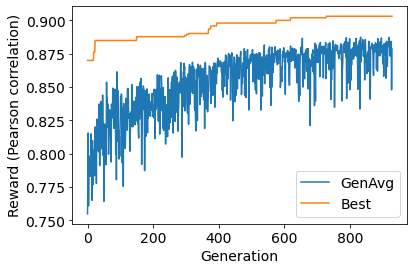

In [17]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


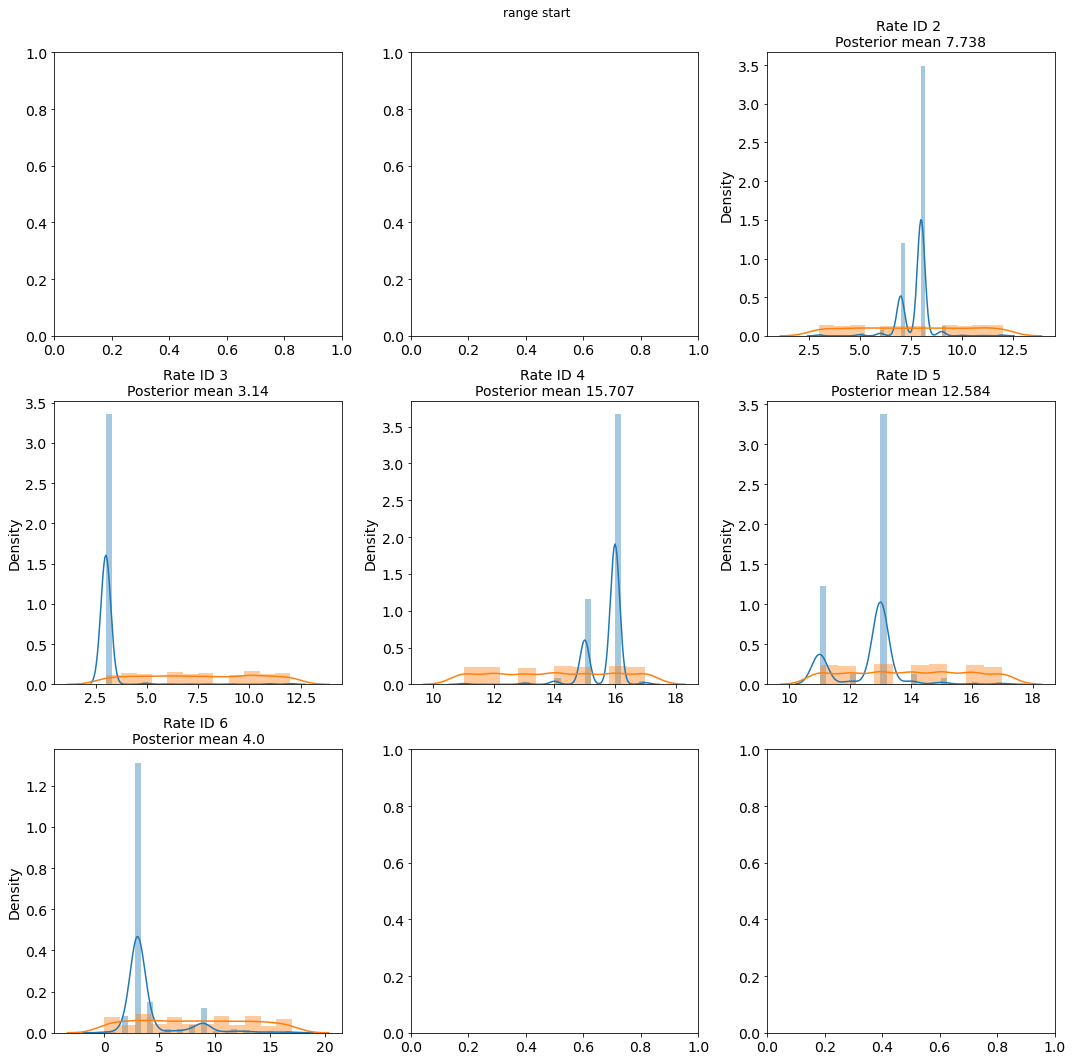

In [18]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

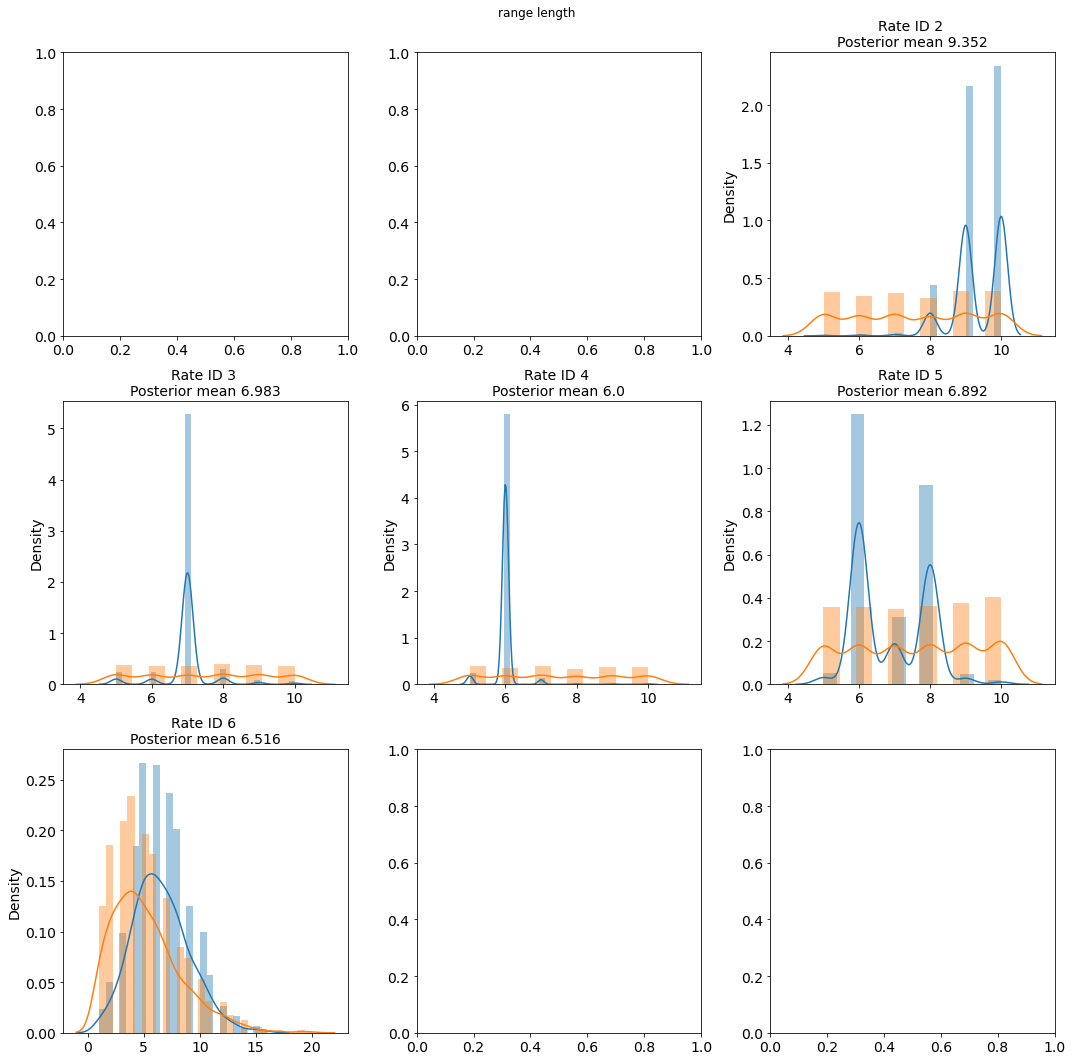

In [19]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

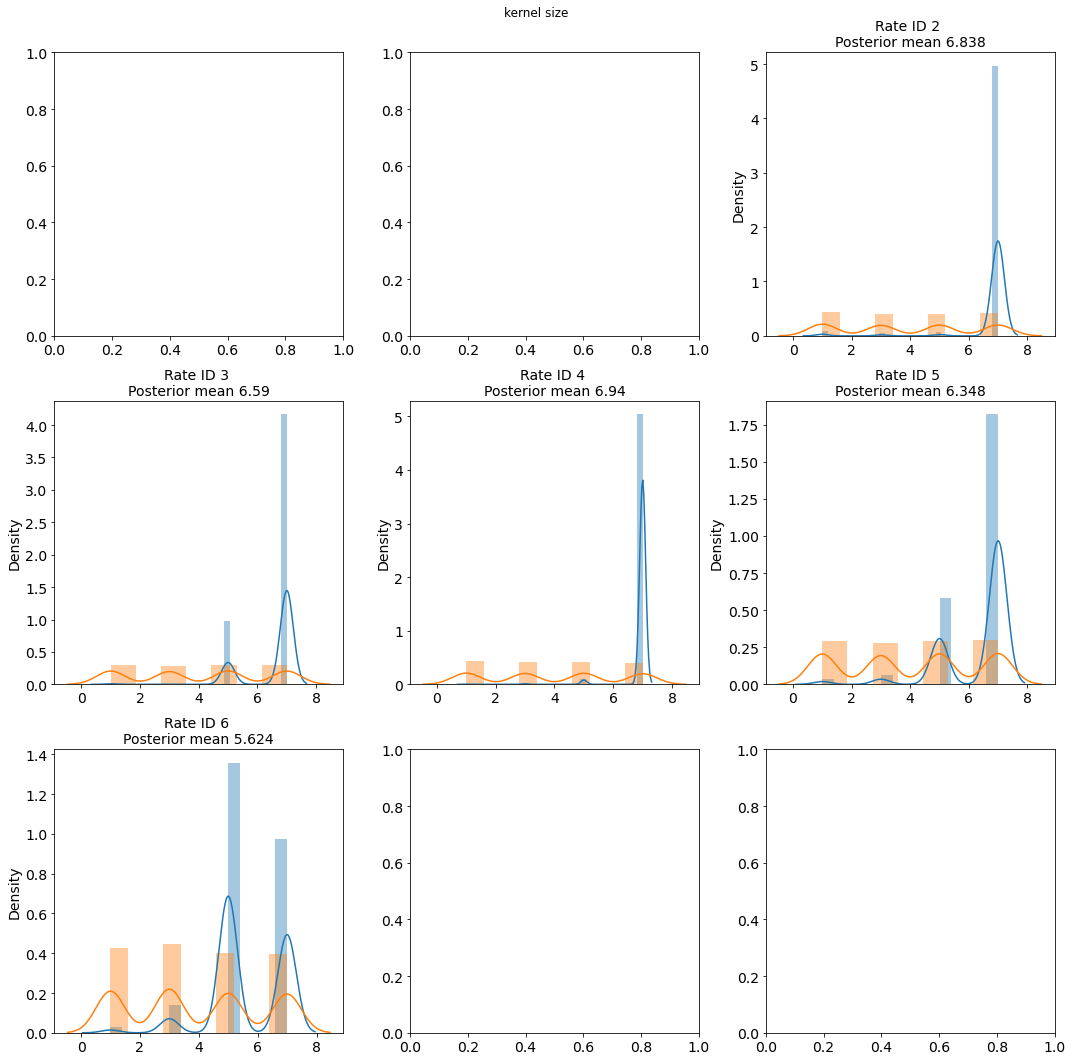

In [20]:
# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20) 
fig.suptitle('kernel size')
fig.tight_layout()

In [21]:
# reload and re-train to full convergence
%run notebooks/reload

<Figure size 432x288 with 0 Axes>

In [22]:
pickle.load(open("outputs/notebook/AmberSearchBestModel_config.pkl", "rb"))

{'States': ['2', '3', '0', '1'],
 'Rates': [{'name': 'k_01',
   'state_list': ['0', '1'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '0',
   'TARGET': '1',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_10',
   'state_list': ['1', '0'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '0',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_12',
   'state_list': ['1', '2'],
   'input_range': [8, 16],
   'kernel_size': 7,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '2',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 8,
   'RANGE_D': 8},
  {'name': 'k_21',
   'state_list': ['2', '1'],
   'input_range': [3, 10],
   'kernel_size': 7,
   'filters': 1,
   'SOURCE': '2',
   'TARGET': '1',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 3,
   'RANGE_D': 7},
  {'name': 'k_23',
   'state_list': ['2', '3'],
   'input_range': [16, 22]

In [23]:
mb = reload_from_dir("outputs/notebook", replace_conv_by_fc=False, n_channels=8)
model = mb.model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 8)]       0                                            
__________________________________________________________________________________________________
input_8_16 (InputLayer)         [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
input_3_10 (InputLayer)         [(None, 7, 8)]       0                                            
__________________________________________________________________________________________________
input_16_22 (InputLayer)        [(None, 6, 8)]       0                                            
______________________________________________________________________________________________

In [24]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)
checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

model.fit(x_train_b, y_train[:,target_idx],
          batch_size=128,
          validation_split=0.2,
          callbacks=[checkpointer, earlystopper],
          epochs=225, verbose=2)
model.load_weights(os.path.join(wd,"bestmodel.h5"))
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]

Train on 3186 samples, validate on 797 samples
Epoch 1/225
3186/3186 - 1s - loss: 0.2478 - val_loss: 0.2507
Epoch 2/225
3186/3186 - 0s - loss: 0.2468 - val_loss: 0.2491
Epoch 3/225
3186/3186 - 0s - loss: 0.2477 - val_loss: 0.2487
Epoch 4/225
3186/3186 - 0s - loss: 0.2481 - val_loss: 0.2564
Epoch 5/225
3186/3186 - 0s - loss: 0.2494 - val_loss: 0.2470
Epoch 6/225
3186/3186 - 0s - loss: 0.2455 - val_loss: 0.2503
Epoch 7/225
3186/3186 - 0s - loss: 0.2468 - val_loss: 0.2493
Epoch 8/225
3186/3186 - 0s - loss: 0.2469 - val_loss: 0.2494
Epoch 9/225
3186/3186 - 0s - loss: 0.2461 - val_loss: 0.2504
Epoch 10/225
3186/3186 - 0s - loss: 0.2463 - val_loss: 0.2462
Epoch 11/225
3186/3186 - 0s - loss: 0.2446 - val_loss: 0.2477
Epoch 12/225
3186/3186 - 0s - loss: 0.2562 - val_loss: 0.2477
Epoch 13/225
3186/3186 - 0s - loss: 0.2537 - val_loss: 0.2646
Epoch 14/225
3186/3186 - 0s - loss: 0.2535 - val_loss: 0.2462
Epoch 15/225
3186/3186 - 0s - loss: 0.2457 - val_loss: 0.2465
Epoch 16/225
3186/3186 - 0s - lo

3186/3186 - 0s - loss: 0.2348 - val_loss: 0.2310
Epoch 133/225
3186/3186 - 0s - loss: 0.2300 - val_loss: 0.2370
Epoch 134/225
3186/3186 - 0s - loss: 0.2316 - val_loss: 0.2399
Epoch 135/225
3186/3186 - 0s - loss: 0.2328 - val_loss: 0.2321
Epoch 136/225
3186/3186 - 0s - loss: 0.2312 - val_loss: 0.2305
Epoch 137/225
3186/3186 - 0s - loss: 0.2302 - val_loss: 0.2316
Epoch 138/225
3186/3186 - 0s - loss: 0.2323 - val_loss: 0.2322
Epoch 139/225
3186/3186 - 0s - loss: 0.2301 - val_loss: 0.2333
Epoch 140/225
3186/3186 - 0s - loss: 0.2318 - val_loss: 0.2481
Epoch 141/225
3186/3186 - 0s - loss: 0.2308 - val_loss: 0.2308
Epoch 142/225
3186/3186 - 0s - loss: 0.2291 - val_loss: 0.2300
Epoch 143/225
3186/3186 - 0s - loss: 0.2303 - val_loss: 0.2304
Epoch 144/225
3186/3186 - 0s - loss: 0.2331 - val_loss: 0.2309
Epoch 145/225
3186/3186 - 0s - loss: 0.2295 - val_loss: 0.2339
Epoch 146/225
3186/3186 - 0s - loss: 0.2311 - val_loss: 0.2318
Epoch 147/225
3186/3186 - 0s - loss: 0.2315 - val_loss: 0.2350
Epoch 

In [25]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [8, 16], 'kernel_size': 7, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 8, 'RANGE_D': 8, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [3, 10], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 7, 'template': None}",
 "{'name': 'k_23', 'state_list': ['2', '3'], 'input_range': [16, 22], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'padding': 'same', 'EDGE': 1

In [26]:
layer_dict = {l.name:l for l in model.layers}

In [27]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[ 0.   ],
        [ 0.   ],
        [ 0.536],
        [ 0.   ],
        [-0.03 ],
        [-0.023],
        [ 0.   ],
        [-0.019]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.536],
        [ 0.   ],
        [-0.028],
        [-0.032],
        [ 0.   ],
        [-0.025]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.536],
        [-0.008],
        [ 0.076],
        [-0.124],
        [ 0.   ]]], dtype=float32)

In [29]:
np.around(layer_dict['conv_k1'].get_weights()[0],3)

array([[[ 0.   ],
        [ 0.   ],
        [ 1.701],
        [ 0.   ],
        [-2.788],
        [-4.896],
        [ 0.   ],
        [-4.484]],

       [[ 0.   ],
        [ 0.   ],
        [ 1.701],
        [ 0.   ],
        [-2.639],
        [-6.271],
        [ 0.   ],
        [-5.385]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 1.701],
        [ 0.057],
        [ 0.249],
        [ 0.036],
        [ 0.   ]]], dtype=float32)

spearman SpearmanrResult(correlation=0.8824801045563582, pvalue=0.0)
pearson (0.9132437176174583, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.913')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


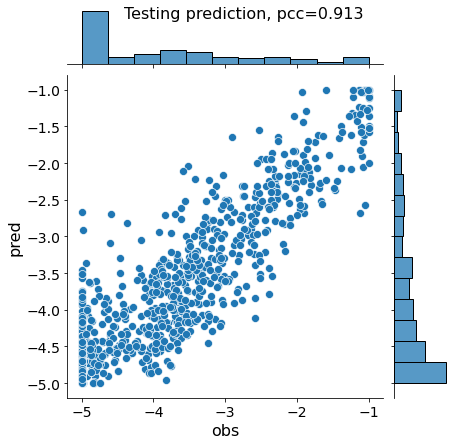

In [28]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test[:,target_idx], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,target_idx]))
p = ss.pearsonr(y_hat, y_test[:,target_idx])
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)